In [66]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py 
import statsmodels.api as sm 

### Data prep

In [99]:
iris = datasets.load_iris()
names = iris.get('target_names')
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df["target"] = pd.Categorical(pd.Series(iris.target).map(lambda x: iris.target_names[x]))

## One-Sided F-test

F-statistic = $\frac{variance between groups}{variance within groups}$

* F-test compares the means of various groups and determines if they are equal by looking at their variance. This is done by checking the variations between the groups and within the groups.

* Goal is to determine that each group's mean value are stastically different from the other's, and to do this we need to evaluate the variability between each of the mean values.

* The null hypothesis asserts that each group's mean value is not statistically different.

* Rejecting the null hypothesis means that there are at least two group means that are statistically significantly different. 

* The F-statistic will always be positive, as it is not possible for it to be negative as it is computed from the ratio of two variances. 

### Data exploration

In [49]:
# 1. What is the overall mean?
df.mean()

sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64

In [50]:
# 2. What are the means of each group?
df.groupby('target').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


## Assumptions of the F-test

* If samples are drawn from normal distributions, the sample variance has a scaled chi square distribution.

* The sampling distribution of a sample variance is directly affected by kurtosis (the sharpness of the peak of a frequency-distribution curve) of the underlying distribution. The flatter or skinnier our sample distribution, the more likely the chi-squared distribution will provide an incorrect answer.

* Properties to hold when performing an F-test

1. Data is normally distributed
2. The samples are independent of one another, and;
3. The population standard deviations of the groups are homoscedastic (the noise is the same across all values of the independent variables).

* We can use the Shapiro-Wilks test to test for a null distribution. The null hypothesis for the Shapiro-Wilks test is that the samples are normally distributed. Thus, if the p value is less then 0.05 the null hypothesis is rejected and there is evidence that the data is not normally distributed.


###  Shapiro-Wilks

In [57]:
# Shapiro-Wilks returns a test statistic and p-value
for name in names:
    print("{}: {}".format(name, stats.shapiro(df['sepal width (cm)'][df['target'] == name])))

setosa: (0.97171950340271, 0.2715264856815338)
versicolor: (0.9741330742835999, 0.33798879384994507)
virginica: (0.9673910140991211, 0.1809043288230896)


### Quantile-Quantile Plot

https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/


https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html

* When the quantiles of two variables are plotted against each other, then the plot obtained is known as quantile - quantile plot. The plot provides a summary of whether the distribution of two variables are similar or not with respect to the locations.


In [97]:
# Data prep
setosa_df = df[df['target'].isin(['setosa'])]
setosa_df = setosa_df.drop('target', axis=1)

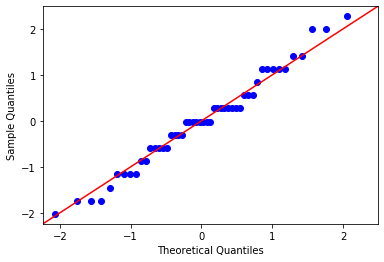

In [98]:
sm.qqplot(setosa_df['sepal length (cm)'], fit=True, line='45')
py.show()

### Barlett test

* Checks for homoscedasticity. 

* If we reject the null hypothesis, we can also reject the assumption of homscedasticity.

* May produce incorrect results if the data is non-normal.

In [115]:
print(stats.bartlett(df['sepal width (cm)'][df['target'] == 'setosa'], 
                     df['sepal width (cm)'][df['target'] == 'versicolor'],
                     df['sepal width (cm)'][df['target'] == 'virginica']))

BartlettResult(statistic=2.0910752014392338, pvalue=0.35150280041580323)


### Levene test

* Checks for homoscedasticity.

* Robust to non normal data

In [116]:
stats.f_oneway(df['sepal width (cm)'][df['target'] == 'setosa'], 
                     df['sepal width (cm)'][df['target'] == 'versicolor'],
                     df['sepal width (cm)'][df['target'] == 'virginica'])

F_onewayResult(statistic=49.160040089612075, pvalue=4.492017133309115e-17)

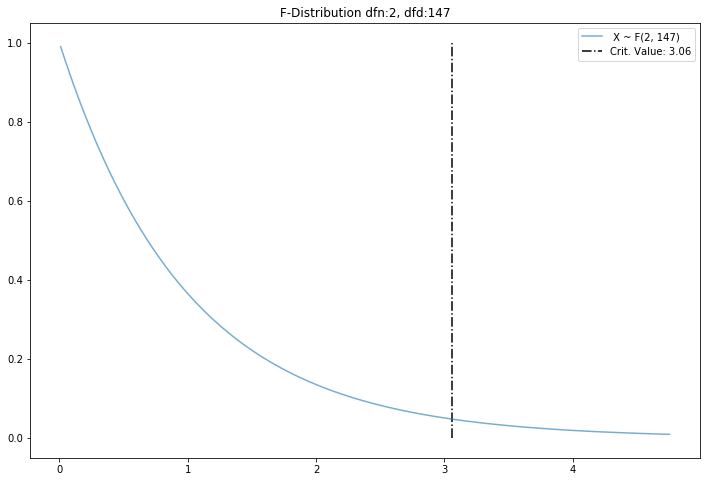

In [117]:
from scipy.stats import f, norm
def plot_f_distrubiton():
    # Set figure 
    plt.figure(figsize=(12, 8))
    
    # Set degrees of freedom
    dfn, dfd = 2, 147
    rejection_reg = f.ppf(q=.95, dfn=dfn, dfd=dfd)
    mean, var, skew, kurt = f.stats(dfn, dfd, moments='mvsk')
    
    x = np.linspace(f.ppf(0.01, dfn, dfd), 
                    f.ppf(0.99, dfn, dfd), 100)
    
    # Plot values
    plt.plot(x, f.pdf(x, dfn, dfd), alpha=0.6, 
             label=' X ~ F({}, {})'.format(dfn, dfd))
    plt.vlines(rejection_reg, 0.0, 1.0, 
               linestyles="dashdot", label="Crit. Value: {:.2f}".format(rejection_reg))
    plt.legend()
    plt.title('F-Distribution dfn:{}, dfd:{}'.format(dfn, dfd))
plot_f_distrubiton();

## Why not multiple t-tests?

* If we were comparing one set of samples to a single grouping of the other two, we could use a t-test at 95 percent confidence interval to compare the two values. Type 1 error would be constant at 5%. 

* However, if we added another comparison and used an additional t-test we're increasing the chance of a Type 1 error.

